# Data Preprocess

In [22]:
import pandas as pd

In [23]:
df_train = pd.read_csv("dataset/train.csv", sep=";")
df_test = pd.read_csv("dataset/test.csv", sep=";")
df_eval = pd.read_csv("dataset/evaluation.csv", sep=";")

## Original dataset concatenated

In [24]:
df = pd.concat([df_train, df_test, df_eval], ignore_index=True)
df.info

<bound method DataFrame.info of        Unnamed: 0                                              title  \
0               0  Palestinians switch off Christmas lights in Be...   
1               1  China says Trump call with Taiwan president wo...   
2               2   FAIL! The Trump Organization’s Credit Score W...   
3               3  Zimbabwe military chief's China trip was norma...   
4               4  THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...   
...           ...                                                ...   
40582        8112   Sean Hannity Throws Hissy Fit After Real Repo...   
40583        8113  FORMER ASST FBI DIRECTOR WARNS ANTI-TRUMP KABA...   
40584        8114   John McCain: Trump’s Attacks On The Press Are...   
40585        8115  Syria's Deir al-Zor air base working again: st...   
40586        8116  U.S. military releases, withdraws old Islamist...   

                                                    text  label  
0      RAMALLAH, West Bank (Reuters) 

## Basic overview of cols and datatypes

In [25]:
df.dtypes

Unnamed: 0     int64
title         object
text          object
label          int64
dtype: object

In [26]:
df.label.value_counts()

label
1    21924
0    18663
Name: count, dtype: int64

In [27]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [28]:
df = df.drop(columns=['Unnamed: 0'])
df['content'] = df['title'] + " " + df['text']

In [29]:
df.head()

,title,text,label,content
0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1,Palestinians switch off Christmas lights in Be...
1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1,China says Trump call with Taiwan president wo...
2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0,FAIL! The Trump Organization’s Credit Score W...
3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1,Zimbabwe military chief's China trip was norma...
4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...


# Data analysis

In [30]:
import seaborn as sb
import matplotlib.pyplot as plt

### Number of characters

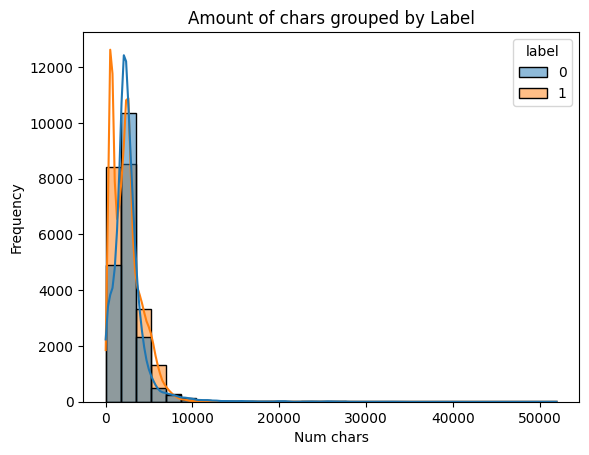

In [31]:
df['text_length'] = df['content'].apply(lambda x : len(str(x)))
sb.histplot(data=df, x='text_length', hue = 'label', bins=30, kde=True)
plt.title("Amount of chars grouped by Label")
plt.xlabel('Num chars')
plt.ylabel("Frequency")
plt.show()

### Number of words

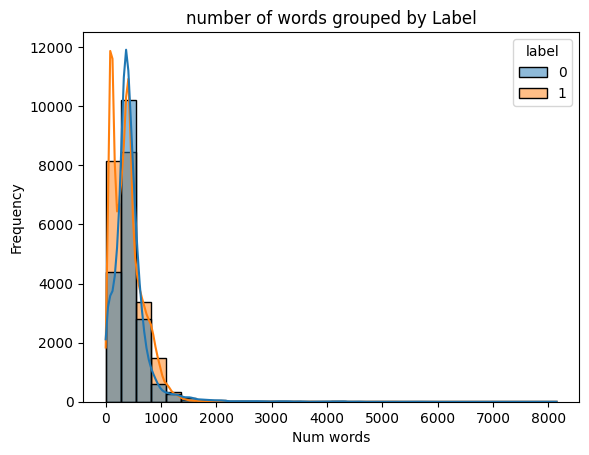

In [32]:
df['num_words'] = df['content'].apply(lambda x : len(str(x).split()))
sb.histplot(data=df, x='num_words', hue = 'label', bins=30, kde=True)
plt.title("number of words grouped by Label")
plt.xlabel('Num words')
plt.ylabel("Frequency")
plt.show()

### TFIDF of every word (excluding stopwords)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

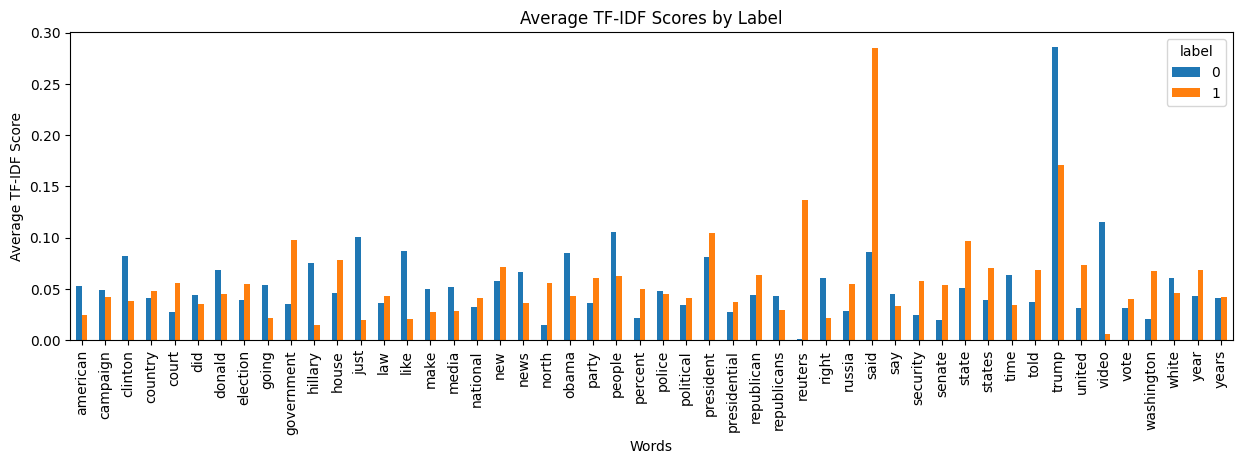

In [34]:
tfidf = TfidfVectorizer(stop_words='english', max_features=50)
tfidf_matrix = tfidf.fit_transform(df['content'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

tfidf_df['label'] = df['label']

tfidf_avg = tfidf_df.groupby('label').mean().T

tfidf_avg.plot(kind='bar', figsize=(15,4))
plt.title('Average TF-IDF Scores by Label')
plt.ylabel('Average TF-IDF Score')
plt.xlabel('Words')
plt.show()

As we can see, there is a lot of words that can possibly go with pairs (n = 2 in ngrams)\
For instance:
- white house
- donald trump
- ... said\
etc.\
So let's dig down

### TFIDF for ngrams with n = 2

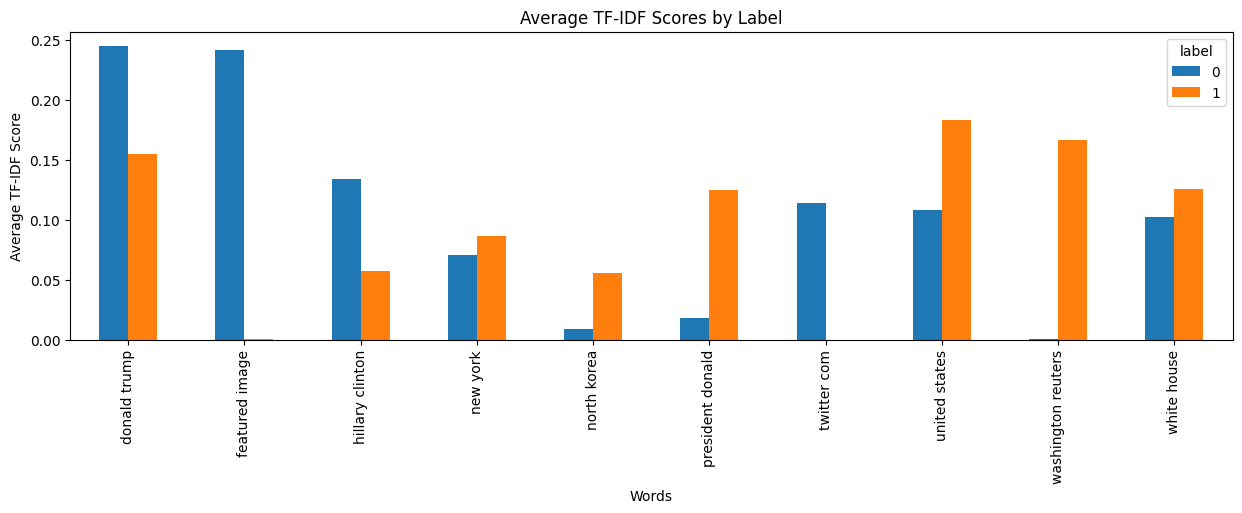

In [35]:
tfidf2 = TfidfVectorizer(stop_words='english', max_features=10, ngram_range=(2, 2))
tfidf_matrix2 = tfidf2.fit_transform(df['content'])
tfidf_df2 = pd.DataFrame(tfidf_matrix2.toarray(), columns=tfidf2.get_feature_names_out())

tfidf_df2['label'] = df['label']

tfidf_avg2 = tfidf_df2.groupby('label').mean().T

tfidf_avg2.plot(kind='bar', figsize=(15,4))
plt.title('Average TF-IDF Scores by Label')
plt.ylabel('Average TF-IDF Score')
plt.xlabel('Words')
plt.show()

TFIDF for both ngranms (n = 1 and n = 2) shows us some correlation between words and labels, so it may be good input to the models.

### Punctuation
There is a lot of news about politics, so punctuation may have impact (Guess: Fake news may contain more '!')

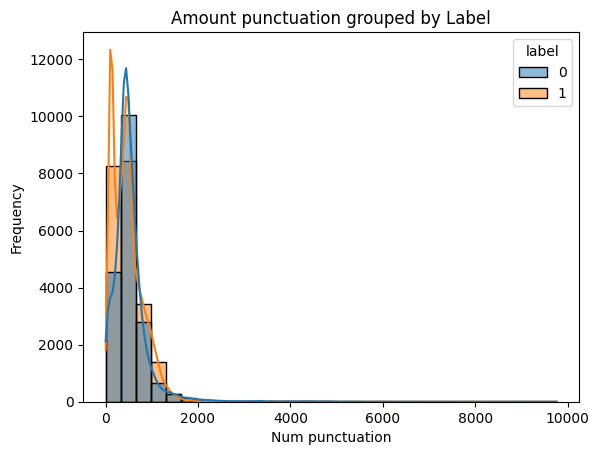

In [48]:
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ 1234567890'
df['punctuation'] = df['content'].apply(lambda x : len([letter for letter in str(x) if letter in punctuation]))
sb.histplot(data=df, x='punctuation', hue = 'label', bins=30, kde=True)
plt.title("Amount punctuation grouped by Label")
plt.xlabel('Num punctuation')
plt.ylabel("Frequency")
plt.show()

Clearly there is similarity with the number of words and number of chars

### Sentiment analysis
If there is so much politics, the text can be filled with positive or negative opinions

In [41]:
from textblob import TextBlob

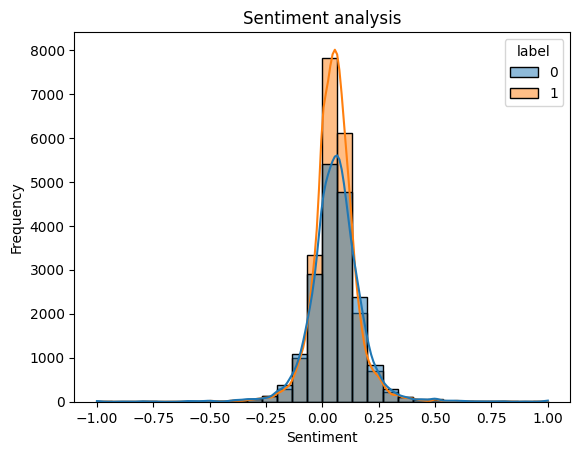

In [47]:
df['sentiment'] = df['content'].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
sb.histplot(data=df, x='sentiment', hue = 'label', bins=30, kde=True)
plt.title("Sentiment analysis")
plt.xlabel('Sentiment')
plt.ylabel("Frequency")
plt.show()

### Correlation of all above things

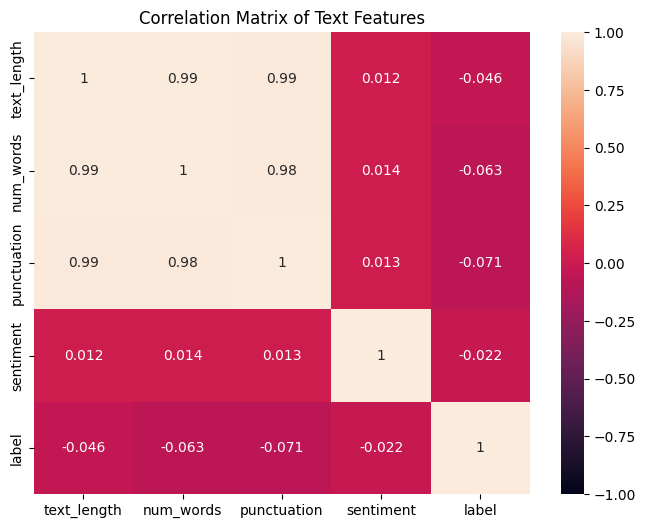

In [46]:
correlation_data = df[
    [
        'text_length', 
        'num_words', 
        'punctuation', 
        'sentiment',
        'label'
    ]
].corr()

# plot correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(data=correlation_data, 
            annot=True, 
            cbar=True, 
            vmin=-1, 
            vmax=1)
plt.title('Correlation Matrix of Text Features')
plt.show()

# Loading data
### Original CSVs
#### Title
```csv
New York Republican Zeldin opposes tax bill
```
#### Text
```csv
WASHINGTON (Reuters) - U.S. Republican Representative Lee Zeldin said he would not support the tax reform legislation 
introduced by Republican congressional leaders on Thursday. “I am a ‘no’ to this bill in its current form. We need to 
fix this state and local tax deduction issue. Adding back in the property tax deduction up to $10,000 is progress, but 
not enough progress,” Zeldin said in a statement. A number of lawmakers from New York opposed eliminating the deduction 
for state and local taxes
```

### Clean CSVs
#### Clean Content (Title + Text)
```csv
new york republican <UNK> <UNK> tax bill washington reuters u republican representative <UNK> <UNK> said would support tax reform legislation <UNK> republican congressional leaders thursday <UNK> bill current form need <UNK> state local tax <UNK> issue adding back <UNK> tax <UNK> 10 000 <UNK> enough <UNK> <UNK> said statement number lawmakers new york <UNK> <UNK> <UNK> state local taxes

```
#### Clean Content Without UNK
```csv
new york republican tax bill washington reuters u republican representative said would support tax reform legislation republican congressional leaders thursday bill current form need state local tax issue adding back tax 10 000 enough said statement number lawmakers new york state local taxes
```
#### Clean Content Without UNK and Trunc'ed (16 words in this example)
```csv
new york republican tax bill washington reuters u republican representative said would support tax reform legislation
```

In [2]:
import time
import string
import re

import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
class DataFrames:
    def __init__(
        self,
        train_file_name: str,
        test_file_name: str,
        evaluation_file_name: str,
    ) -> None:
        self.content_col_name: str = "content"
        self.content_clean_col_name: str = "content_clean"
        self.content_clean_col_name_no_UNK: str = "content_clean_no_UNK"
        self.content_clean_col_name_truc: str = "content_clean_truc"
        self.label_col_name: str = "label"
        self.train: pd.DataFrame = self.load_data(train_file_name)
        self.test: pd.DataFrame = self.load_data(test_file_name)
        self.evaluation: pd.DataFrame = self.load_data(evaluation_file_name)

    def load_data(self, file_name: str) -> pd.DataFrame:
        df = pd.read_csv(f"dataset/{file_name}.csv", sep=";")
        df.dropna(inplace=True)
        if not self.content_clean_col_name in df.columns:
            df[self.content_col_name] = df["title"] + " " + df["text"]
            df = df.drop(columns=["Unnamed: 0"])
        return df

    def get_datasets(self) -> list[pd.DataFrame]:
        return [self.train, self.test, self.evaluation]

    def get_info(self) -> str:
        test_info = self.test.shape
        train_info = self.train.shape
        evaluation_info = self.evaluation.shape
        return f"DataFrame Shapes:\n\tTrain: {train_info}\n\tTest: {test_info}\n\tEvaluation: {evaluation_info}\n"

    def save_clean(self, token_limit: int = 10000, num_words_trunc: int = 256) -> None:
        # CLEAN
        self._init_clean_content([self.train, self.test, self.evaluation])
        self.train = self.clean_df(self.train)
        self.test = self.clean_df(self.test)
        self.evaluation = self.clean_df(self.evaluation)

        most_common_words = self.get_most_common_words_counter(
            [self.test, self.train],
            token_limit,
            self.content_clean_col_name,
        )
        self.train = DataFrames.set_least_common_UNK(
            self.train, "content_clean", most_common_words
        )
        self.test = DataFrames.set_least_common_UNK(
            self.test, "content_clean", most_common_words
        )
        self.evaluation = DataFrames.set_least_common_UNK(
            self.evaluation, "content_clean", most_common_words
        )
        self.train = DataFrames.drop_least_common(
            self.train,
            self.content_clean_col_name,
            self.content_clean_col_name_no_UNK,
            most_common_words,
        )
        self.test = DataFrames.drop_least_common(
            self.test,
            self.content_clean_col_name,
            self.content_clean_col_name_no_UNK,
            most_common_words,
        )
        self.evaluation = DataFrames.drop_least_common(
            self.evaluation,
            self.content_clean_col_name,
            self.content_clean_col_name_no_UNK,
            most_common_words,
        )
        self.train = DataFrames.trunc_text(
            self.train,
            self.content_clean_col_name_no_UNK,
            self.content_clean_col_name_truc,
            num_words_trunc,
        )
        self.test = DataFrames.trunc_text(
            self.test,
            self.content_clean_col_name_no_UNK,
            self.content_clean_col_name_truc,
            num_words_trunc,
        )
        self.evaluation = DataFrames.trunc_text(
            self.evaluation,
            self.content_clean_col_name_no_UNK,
            self.content_clean_col_name_truc,
            num_words_trunc,
        )
        # SAVE
        cols_to_save_clean: list[str] = [
            self.content_clean_col_name,
            self.content_clean_col_name_no_UNK,
            self.content_clean_col_name_truc,
            self.label_col_name,
        ]
        self.train.to_csv(
            f"dataset/train_clean.csv",
            sep=";",
            columns=cols_to_save_clean,
        )
        self.test.to_csv(
            f"dataset/test_clean.csv",
            sep=";",
            columns=cols_to_save_clean,
        )
        self.evaluation.to_csv(
            f"dataset/evaluation_clean.csv",
            sep=";",
            columns=cols_to_save_clean,
        )

    def num_unique_words(self, col_name: str) -> int:
        result: set = set()
        df = pd.concat([self.train, self.test, self.evaluation], ignore_index=True)
        df[col_name].str.lower().str.split().apply(result.update)
        return len(result)

    def get_vocab(self, col_name) -> dict[str, int]:
        vectorizer = CountVectorizer()
        for df in [self.train, self.test, self.evaluation]:
            vectorizer.fit_transform(df[col_name].values)
        return vectorizer.vocabulary_

    def _init_clean_content(self, dfs: list[pd.DataFrame]) -> list[pd.DataFrame]:
        for df in dfs:
            df[self.content_clean_col_name] = df[self.content_col_name]
        return dfs

    def clean_df(self, df: pd.DataFrame) -> pd.DataFrame:
        df = self.to_lower(df, self.content_clean_col_name)
        df = self.remove_punctuation(df, self.content_clean_col_name)
        df = self.remove_stopword(df, self.content_clean_col_name)
        return df

    @staticmethod
    def to_lower(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
        df[col_name] = df[col_name].apply(lambda x: str(x).lower())
        return df

    @staticmethod
    def remove_punctuation(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
        re_punctuation = f'[{re.escape(string.punctuation)}"”“]'
        df[col_name] = df[col_name].apply(
            lambda x: re.sub(re_punctuation, " ", str(x))
            .lower()
            .replace("'s", "")
            .replace("’s", "")
        )
        return df

    @staticmethod
    def remove_stopword(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
        stop_words = set(stopwords.words("english"))
        df[col_name] = df[col_name].apply(
            lambda x: " ".join(
                word for word in str(x).split() if not word in stop_words
            )
        )
        return df

    @staticmethod
    def get_most_common_words_counter(
        dfs: list[pd.DataFrame],
        token_limit: int,
        col_name: str,
    ) -> Counter:
        word_counter: Counter = Counter()
        for df in dfs:
            if col_name not in df.columns:
                raise ValueError("Each DataFrame must have a 'clean_content' column")
            tokens = " ".join(df[col_name].astype(str)).split()
            word_counter.update(tokens)
        return Counter(dict(word_counter.most_common(token_limit)))

    @staticmethod
    def set_least_common_UNK(
        df: pd.DataFrame,
        col_name: str,
        most_common_words: Counter,
    ) -> pd.DataFrame:
        df[col_name] = df[col_name].apply(
            lambda x: " ".join(
                [
                    word if word in most_common_words else "<UNK>"
                    for word in str(x).split()
                ]
            )
        )
        return df

    @staticmethod
    def drop_least_common(
        df: pd.DataFrame,
        col_name: str,
        col_name_no_unk: str,
        most_common_words: Counter,
    ) -> pd.DataFrame:
        df[col_name_no_unk] = df[col_name].apply(
            lambda x: " ".join(
                [word for word in str(x).split() if word in most_common_words]
            )
        )
        return df

    @staticmethod
    def trunc_text(
        df: pd.DataFrame,
        col_name: str,
        col_name_trunc: str,
        trunc_num: int,
    ) -> pd.DataFrame:
        df[col_name_trunc] = df[col_name].apply(
            lambda x: " ".join(str(x).split()[:trunc_num])
        )
        return df

    @staticmethod
    def label_to_str(label: int) -> str:
        return "Fake" if label == 1 else "Not Fake"

In [7]:
data_frames = DataFrames("train", "test", "evaluation")
data_frames_unique = data_frames.num_unique_words("content")
print(f"Unique words dataframes: {data_frames_unique}")

data_frames.save_clean(
    token_limit=1000,
    num_words_trunc=16,
)

data_frames_clean = DataFrames("train_clean", "test_clean", "evaluation_clean")
data_frames_clean_unique = data_frames_clean.num_unique_words("content_clean")
print(f"Unique words dataframes clean: {data_frames_clean_unique}")

Unique words dataframes: 394396
Unique words dataframes clean: 1001
